In [1]:
from dariah_topics import preprocessing as pre
from dariah_topics import visualization as visual
from dariah_topics import mallet as mal
from dariah_topics import evaluation

INFO summa.preprocessing.cleaner: 'pattern' package not found; tag filters are not available for English


## Preprocessing

#### Liste mit Dateinamen erzeugen

In [2]:
path_txt = "corpus_txt"
#path_txt = "grenzbote_plain/*/"

doclist_txt = pre.create_document_list(path_txt)
assert doclist_txt, "No documents found"
doclist_txt[:5]

INFO preprocessing: Creating document list from TXT files ...


['corpus_txt/Howard_TheDevilinIron.txt',
 'corpus_txt/Poe_EurekaAProsePoem.txt',
 'corpus_txt/Doyle_AScandalinBohemia.txt',
 'corpus_txt/Poe_TheCaskofAmontillado.txt',
 'corpus_txt/Kipling_ThyServantaDog.txt']

In [3]:
path_csv = "corpus_csv"

doclist_csv = pre.create_document_list(path_csv, 'csv')
doclist_csv[:5]

INFO preprocessing: Creating document list from CSV files ...


['corpus_csv/Kipling_TheJungleBook.txt.csv',
 'corpus_csv/Kipling_ThyServantaDog.txt.csv',
 'corpus_csv/Howard_SchadowsinZamboula.txt.csv',
 'corpus_csv/Poe_TheMasqueoftheRedDeath.txt.csv',
 'corpus_csv/Howard_GodsoftheNorth.txt.csv']

In [4]:
path_tei = "corpus_tei"

doclist_tei = pre.create_document_list(path_tei, 'xml')
doclist_tei[:5]

INFO preprocessing: Creating document list from XML files ...


['corpus_tei/Schnitzler_DerAndere.xml',
 'corpus_tei/Schnitzler_DerWitwer.xml',
 'corpus_tei/Schnitzler_DieFremde.xml',
 'corpus_tei/Schnitzler_Amerika.xml',
 'corpus_tei/Schnitzler_GeschichteeinesGenies.xml']

#####  Liste mit Dokumentenlabels erzeugen - (Funktion wird durch Thorsten's generischere Funktion ersetzt)

In [5]:
doc_labels = list(pre.get_labels(doclist_txt))
doc_labels[:5]

INFO preprocessing: Creating document labels ...


['Howard_TheDevilinIron',
 'Poe_EurekaAProsePoem',
 'Doyle_AScandalinBohemia',
 'Poe_TheCaskofAmontillado',
 'Kipling_ThyServantaDog']

#### Corpus laden

In [6]:
corpus_txt = pre.read_from_txt(doclist_txt)

In [7]:
corpus_csv = pre.read_from_csv(doclist_csv)

In [8]:
corpus_tei = pre.read_from_tei(doclist_tei)

#### Tokenisieren

In [9]:
doc_tokens = pre.filter_pos_tags(list(corpus_csv)[0])
list(doc_tokens)[0][:5]

INFO preprocessing: Accessing CSV documents ...
INFO preprocessing: Accessing ['ADJ', 'V', 'NN'] ...


6     contents
66       bring
67        home
69       night
74         set
Name: Lemma, dtype: object

In [10]:
doc_tokens = [list(pre.tokenize(tei)) for tei in list(corpus_tei)]
doc_tokens[0][:5]

INFO preprocessing: Accessing TEI XML documents ...


['arthur', 'schnitzler', 'der', 'andere', 'aus']

In [11]:
doc_tokens = [list(pre.tokenize(txt)) for txt in list(corpus_txt)]
doc_tokens[0][:5]

INFO preprocessing: Accessing TXT documents ...


['the', 'devil', 'in', 'iron', 'by']

#### Create Dictionaries

In [12]:
id_types = pre.create_dictionary(doc_tokens)
doc_ids = pre.create_dictionary(doc_labels)

#### Sparse BOW Model

In [13]:
sparse_bow = pre.create_sparse_bow(doc_labels, doc_tokens, id_types, doc_ids)

In [14]:
sparse_bow[:5]

0
doc_id token_id   
1      1         1
       2         3
       16388     2
       5         1
       16390     1

#### Convert to Doc-Topic Matrix

'''import pandas as pd

doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

cols = [doc2id[key] for key in set(sparse_bow.index.get_level_values("doc_id"))]
#idx = [type2id[key] for key in set(sparse_bow.index.get_level_values("token_id"))]

set(sparse_bow.index.get_level_values("token_id"))

#doctopic_matrix = pd.DataFrame(columns=cols, index=idx)'''

#### Remove Features

In [15]:
import os.path
basepath = os.path.abspath('.')

with open(os.path.join(basepath, "tutorial_supplementals", "stopwords", "en.txt"), 'r', encoding = 'utf-8') as f: 
    stopword_list = f.read().split('\n')
    
stopword_list = set(stopword_list)

##### Create Feature Remove Lists

In [16]:
stopword_list = pre.find_stopwords(sparse_bow, id_types, 100)
len(stopword_list)

INFO preprocessing: Finding stopwords ...


100

In [17]:
hapax_list = pre.find_hapax(sparse_bow, id_types)
len(hapax_list)

INFO preprocessing: Finding hapax legomena ...


9787

## Topic Modeling with Gensim

##### Saving Sparse BOW

In [18]:
#num_docs = max(sparse_bow.index.get_level_values("doc_id"))
#num_types = max(sparse_bow.index.get_level_values("token_id"))
#sum_counts = sum(sparse_bow[0])

#header_string = str(num_docs) + " " + str(num_types) + " " + str(sum_counts) + "\n"

#with open("gb_plain.mm", 'w', encoding = "utf-8") as f:
#    pass

#with open("gb_plain.mm", 'a', encoding = "utf-8") as f:
#    f.write("%%MatrixMarket matrix coordinate real general\n")
#    f.write(header_string)
#    sparse_bow.to_csv( f, sep = ' ', header = None)

pre.save_sparse_bow(sparse_bow, "gensim_txt")

#### Import Market Matrix

In [19]:
from gensim.models import LdaModel
from gensim.corpora import MmCorpus

In [20]:
mm = MmCorpus("gensim_txt.mm")

INFO gensim.matutils: initializing corpus reader from gensim_txt.mm
INFO gensim.matutils: accepted corpus with 17 documents, 22232 features, 369906 non-zero entries


In [21]:
#in case you're only loading the corpus - build dict first

#import pickle

#pickle.dump( id_types, open( "gb_plain.dictionary", "wb" ) )

In [22]:
#id_types = pickle.load(open("gb_plain.dictionary", 'rb'))

In [23]:
#mm = gensim.corpora.MmCorpus("gb_all.mm")

In [24]:
#id_types = pickle.load(open("gb_all.dictionary", 'rb'))

In [25]:
doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

In [26]:
#model = LdaModel(corpus=mm, id2word=type2id, num_topics=60, alpha = "symmetric", passes = 10) #import momentan in visual 
# -> da ich mir noch nicht sicher bin, welche Funktionen in das tm_gensim.py sollen
model = LdaModel(corpus=mm, id2word=type2id, num_topics=10)

INFO gensim.models.ldamodel: using symmetric alpha at 0.1
INFO gensim.models.ldamodel: using symmetric eta at 4.49781855799937e-05
INFO gensim.models.ldamodel: using serial LDA version on this node
INFO gensim.models.ldamodel: running online LDA training, 10 topics, 1 passes over the supplied corpus of 17 documents, updating model once every 17 documents, evaluating perplexity every 17 documents, iterating 50x with a convergence threshold of 0.001000
WARNING gensim.models.ldamodel: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
INFO gensim.models.ldamodel: -11.204 per-word bound, 2359.0 perplexity estimate based on a held-out corpus of 17 documents with 369906 words
INFO gensim.models.ldamodel: PROGRESS: pass 0, at document #17/17
INFO gensim.models.ldamodel: topic #3 (0.100): 0.066*"transposed" + 0.033*"bamboo" + 0.031*"danish" + 0.017*"discussing" + 0.015*"eccentric" + 0.015*"creating" + 0.014*"trench" + 0.009*

In [27]:
#Anzeige der keywords für topic n
n = 1
topic_nr_x = model.get_topic_terms(n)

topicTerms = [type2id[i[0]] for i in topic_nr_x]
topicTerms

['transposed',
 'bamboo',
 'danish',
 'discussing',
 'eccentric',
 'seems',
 'creating',
 'solving',
 'outboardoh',
 'trench']

In [28]:
#Anzeige der id des ersten keywords aus dem topic
'''n = 0
for key, value in type2id.items():
    if value == topicTerms[n]:
        print(key)'''

'n = 0\nfor key, value in type2id.items():\n    if value == topicTerms[n]:\n        print(key)'

In [29]:
#Gensim-Funktion -> Anzeige des word_id-probability-mappings eines topics n
'''n = 0
topicN = model.get_topic_terms(n)
topicN'''

'n = 0\ntopicN = model.get_topic_terms(n)\ntopicN'

In [30]:
#Topic probabilities
topics = model.show_topics(num_topics = 10)
topics[:2]

[(0,
  '0.063*"transposed" + 0.033*"danish" + 0.026*"bamboo" + 0.025*"discussing" + 0.017*"eccentric" + 0.015*"seems" + 0.011*"solving" + 0.010*"enoch" + 0.009*"trench" + 0.009*"creating"'),
 (1,
  '0.065*"transposed" + 0.035*"bamboo" + 0.032*"danish" + 0.024*"discussing" + 0.017*"eccentric" + 0.014*"seems" + 0.012*"creating" + 0.011*"solving" + 0.011*"outboardoh" + 0.010*"trench"')]

from scipy.io import mmread
test = mmread("gb_plain.mm")
import pandas as pd
pd.DataFrame(test.data)

## Visualisierung 

In [31]:
'''lda_model = 'out_easy/corpus.lda'
corpus = 'out_easy/corpus.mm'
dictionary = 'out_easy/corpus.dict'
doc_labels = 'out_easy/corpus_doclabels.txt'
interactive  = False

vis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)'''

"lda_model = 'out_easy/corpus.lda'\ncorpus = 'out_easy/corpus.mm'\ndictionary = 'out_easy/corpus.dict'\ndoc_labels = 'out_easy/corpus_doclabels.txt'\ninteractive  = False\n\nvis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)"

##### Create a document-topic matrix (that is a pandas data frame actually)

In [32]:
doc_topic = visual.create_doc_topic(mm, model, doc_labels)

##### Visualize document-topic matrix

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

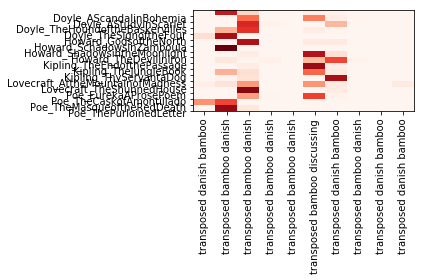

In [33]:
%matplotlib inline
visual.doc_topic_heatmap(doc_topic)

##### Visualize topic distribution in a single document

<module 'matplotlib.pyplot' from '/usr/lib/python3/dist-packages/matplotlib/pyplot.py'>

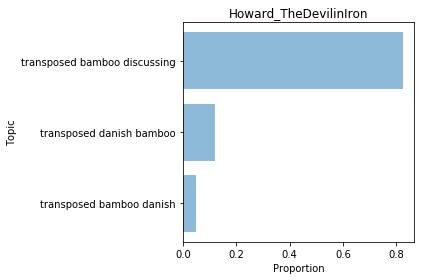

In [34]:
visual.plot_doc_topics(doc_topic, 0)

#### Heatmap

In [35]:
#heatmap = visual.make_heatmap()

In [36]:
#visual.save_heatmap("./visualizations/heatmap")

#### Interactive

In [37]:
#vis = collection.Visualization(lda_model, corpus, dictionary, doc_labels, interactive=True)

In [38]:
#vis.make_interactive()

In [39]:
#vis.save_interactive("./visualizations/interactive")

## Evaluation

In [40]:
segmented_topics = evaluation.topic_segmenter(model, type2id, 10)
segmented_topics[0][:5]

[('transposed', 'danish'),
 ('transposed', 'bamboo'),
 ('transposed', 'discussing'),
 ('transposed', 'eccentric'),
 ('transposed', 'seems')]

In [41]:
umass_probability = evaluation.token_probability(doc_tokens, segmented_topics)
umass_probability

discussing                                    {13, 15}
eccentric                                  {8, 10, 13}
aghast                                     {11, 4, 13}
war-chariot                                        {5}
danish                                            {10}
ants                                       {11, 6, 14}
bamboo                                         {12, 6}
enoch                                             {10}
trench                                            {13}
seems          {1, 2, 4, 6, 7, 10, 11, 12, 13, 15, 16}
creating                                          {11}
transposed                                        {12}
outboardoh                                         {4}
solving                                           {10}
dtype: object

In [42]:
umass = evaluation.calculate_umass(segmented_topics, umass_probability, doc_tokens, 10)
umass

0.016996836206907753

In [43]:
wiki_list = evaluation.wikipedia_table_crawler()

In [44]:
wiki_corpus = evaluation.wikipedia_crawler(wiki_list, size=5)

In [45]:
uci_probability = evaluation.token_probability(wiki_corpus, segmented_topics)

In [46]:
pmi = evaluation.calculate_pointwise_mutual_information(segmented_topics, wiki_corpus, uci_probability)

In [47]:
uci = evaluation.calculate_uci(pmi, wiki_corpus, 10)
uci

0.0

![success](http://cdn2.hubspot.net/hub/128506/file-446943132-jpg/images/computer_woman_success.jpg)